## Importing Required Packges

In [255]:
#Loading libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy import ndimage
import math
import keras
import ast
import operator as op
import re
from IPython import display
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Suppressing warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Loading the model used for training the digits and symbols

In [256]:
# Variables to store cleaned and original imgages
clean_image_dict = {} #dictionary of binary image
original_image_dict = {} # dictionary of original image

#Keras support channel first (1,28,28) only
keras.backend.set_image_data_format("channels_first")


In [257]:
#loading model weights saved after traing DCCNN neural network model
try:
    model = keras.models.load_model('C:/Users/Abhishek/Desktop/final_project/Autograding-handwritten-mathematical-worksheets-master/models/DCNN.h5', compile=False)

except Exception as e:
    print('Model couldnot be loaded',e)

## Functions required for image preprocessing, workspace detection, line isolation and character segmentations.

#### Function to Resize Image
This function takes in input of the image and resizes it as per the required width and height passed to it.


In [258]:

def image_resize(image, width = None, height = None, inter = cv2.INTER_LINEAR):
    
    '''
    Function description
    image_resize : The objective of the functions is to resize images.
    argument's: This function takes in following input
        image (Matrix)  : source/input image to resize
        width (Integer) : width of the required image 
        height (Integer): height of required image
        inter (Method)  : flag that takes Interpolation/Extrapolation method,
                          default is set to INTER_LINEAR(a bilinear interpolation)
    output:
        image (Matrix)  : Returns a resized image
    '''
    
    dim = None
    (h, w) = image.shape[:2] # storing the dimesion in h and w in a tuple.

    # Return the original image if both the width and height are None.
    if width is None and height is None:
        return image

    # to verify that the width is None.
    if width is None:
        # Calculate the height-to-length ratio and build the dimensions
        ratio = height / float(h)
        dim = (int(w * ratio), height)

    # otherwise, the height is None
    else:
        # Calculate the width ratio and build the dimensions
        ratio = width / float(w)
        dim = (width, int(h * ratio))

    # OpenCV Resize image using cv2.resize(), https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/
    resized_image = cv2.resize(image, dim, interpolation = inter) 

    # returning the resized image
    return resized_image


obtainBestShift() and shift() functions are used to find the best shift directions and then shift the image in the specific directions respectively.

In [259]:

def obtainBestShift(img):
    '''
    Function Description
    obtainBestShift : This function is used to determine the image's center of mass and obtain the optimal shifts.
    argument:
        img (array) : gray scale image
    output:
        shift_x_direction, shift_y_direction: x,y shift direction
    '''
    cy,cx = ndimage.measurements.center_of_mass(img) # Calculate the center of mass of the values of an array passed.
    rows,cols = img.shape
    shift_x_direction = np.round(cols/2.0-cx).astype(int)
    shift_y_direction = np.round(rows/2.0-cy).astype(int)

    return shift_x_direction,shift_y_direction


def shift(img,sx,sy):
    '''
    Shift : This function is used to move the image in a specific direction.
    argument:
        img (array) : gray scale image to be shifted
        sx, sy      : x, y direction
    output:
        shifted : shifted image in a specific direction
        
    sources:  
       cv2.warpAffine :  https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
       ImageDataGenerator: https://theailearner.com/tag/cv2-warpaffine/
    '''
    #Applies an Affine Transform to the image. This transform is obtained from the relation between three points.
    #An affine transformation is any transformation that preserves collinearity, parallelism as well as the ratio of distances between the points
    #(e.g. midpoint of a line remains the midpoint after transformation).
    #It doesn’t necessarily preserve distances and angles. 
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted




#### Function to pre-process the images
pre_process_img() is used to pre-process the image for prediction, i.e it used to change each image passed in it to the specificatios of mnist and kaggle's data used for trainng the model before using the specific image for prediction.
Making a binary image with a black backdrop and white symbols, Dilating by a 3 * 3 kernel, Image Smoothing by applying gaussian blur, helps in reducing noise. Padding the image to 20 X 20 while keeping the aspect ratio, The picture is padded to a size of 28 * 28 by the center of mass. Obtaining the best shift directions of the image from and shifting them in the particular direction using the obtainBestShift() and shift() functions respectively. Finally normlizing the image.


In [260]:
def pre_process_img(gray, resize_flag = 1, preproc = 0):
    '''
    Function Description
    pre_process_img  : The objective of this function is to pre process image for prediction
    argument:
        gray (Matrix (np.uint8))  : character image to be resized and processed
        resize_flag               : method used for resizing image
        preproc (method [bool])   : 0 Indictes erosion, Dilation need not be done, 1 indicates Erosion, Dilation needs to be done
    output:
        grayS (Matrix (0-1))      : Image of a character that has been normalized, scaled, and processed
    

    '''    
    gray = gray.copy()
    
    #Image Pre Processing
    if (preproc == 0):
        gray = cv2.GaussianBlur(gray,(7,7),0) # cv2.gaussianblur() to apply Gaussian Smoothing on the input source image
    else :
        kernel = np.ones((3,3), np.uint8)
        gray = cv2.dilate(gray, kernel, iterations=1)  # Dilations increase the size of foreground objects  
        gray = cv2.GaussianBlur(gray,(5,5),1) # Image Smoothing by applying gaussian blur, helps in reducing noise.
        gray = cv2.dilate(gray, kernel, iterations=2) 
        gray = cv2.erode(gray, kernel,iterations=2)  # pixels near the boundary of an object in an image will be discarded, “eroding” it away.  
    
    #Getting rid of rows and columns when every pixel is black
    while np.sum(gray[0]) == 0:
        gray = gray[1:]

    while np.sum(gray[:,0]) == 0:
        gray = np.delete(gray,0,1)

    while np.sum(gray[-1]) == 0:
        gray = gray[:-1]

    while np.sum(gray[:,-1]) == 0:
        gray = np.delete(gray,-1,1)

    rows,cols = gray.shape
    
    if(resize_flag) == 1:
        interpolation=cv2.INTER_AREA
    else:
        interpolation=cv2.INTER_CUBIC
    # Before resizing, keeping the aspect ratio same.
    if rows > cols:
        factor = 20.0/rows
        rows = 20
        cols = int(round(cols*factor))
        # first cols than rows
        gray = cv2.resize(gray, (cols,rows),interpolation=interpolation)
    else:
        factor = 20.0/cols
        cols = 20
        rows = int(round(rows*factor))
        # first cols than rows
        gray = cv2.resize(gray, (cols, rows),interpolation=interpolation)
   
    # Padding to a 28 * 28 image
    column_padding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
    row_padding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
    gray = np.lib.pad(gray,(row_padding,column_padding),'constant')
    
    # obtaining the best shifts possible.
    shift_x_direction,shift_y_direction = obtainBestShift(gray)
    shifted = shift(gray,shift_x_direction,shift_y_direction)
    grayS = shifted
    grayS = grayS.reshape(1,1,28,28)
    
    #Normalizing the image
    grayS = grayS/255
    
    return grayS

 
 eval method in Python allows us to evaluate arbitrary Python expressions from a text or compiled code input.
    When we need to dynamically evaluate Python expressions from any input, whether it's a string or a built code object,
    this method comes in useful. So, it is used to solve any arithmetic equation identified  from each extracted lines.

In [261]:
'''
Evaluate New
'''
# Dictionary of the supported operators
operators = {ast.Add: op.add, ast.Sub: op.sub, ast.Mult: op.mul,
             ast.Div: op.truediv, ast.Pow: op.pow, ast.BitXor: op.xor,
             ast.USub: op.neg}

def eval_expr(expr):
    
    """
    eval method in Python allows us to evaluate arbitrary Python expressions from a text or compiled code input.
    When we need to dynamically evaluate Python expressions from any input, whether it's a string or a built code object,
    this method comes in useful. So, it is used to solve any arithmetic equation identified  from each extracted lines. The built-in Python eval function may be used to dynamically evaluate expressions from
    a string or compiled code input. When we give eval a text, it parses it, converts it to bytecode, and evaluates it
    as a Python expression. When we call eval with a built code object, however, the method just executes the evaluation
    step, which is useful if you run eval several times with the same input.
    
    >>> eval_expr('2^6')
    4

    """
    return eval_(ast.parse(expr, mode='eval').body)

def eval_(node):
    # isinstance() function returns True if the specified object is of the specified type, otherwise False.
    if isinstance(node, ast.Num): # <number> 
        return node.n
    elif isinstance(node, ast.BinOp): # <left> <operator> <right>
        return operators[type(node.op)](eval_(node.left), eval_(node.right))
    elif isinstance(node, ast.UnaryOp): # <operator> <operand> e.g., -1
        return operators[type(node.op)](eval_(node.operand))
    else:
        raise TypeError(node)


#### Sort Contours funtion

This function makes a list of all bounding boxes and then uses cv2.boundingRect() on each image co, ntours to return the 4 numeric values corresponfing to the x-cor, y-cor, width, height respectively of the bounding box, which are then soretd and the sorted contours and bounding boxes are retuned in form of a list.

In [262]:
def sort_contours(img_contours, method="left-to-right"):
    '''
    Function description
    sort_contours : The objective of the functions is to sort contours.
    argument:
        img_contours (array): image contours
        method(string) : sorting direction used
    output: The sort contours function returns contours and bounding boxes (top-left and bottom-right coordinates)
    that have been sorted according to the manner we specified. 
        img_contours(list): sorted contours
        boundingBoxes(list): bounding boxes
    '''
    # initialization of the reverse flag and sort index
    reverse = False
    i = 0

    # check if we are sorting in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # Check if we're sorting by the bounding box's y-coordinate rather than the x-coordinate
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # Make a list of all the bounding boxes and order them from top to bottom.
    # CV2 boundingrect() is a function used to create an approximate rectangle along with the image.
    # CV2 Boundingrect returns 4 numeric values when the contour is passed as an argument. 
    # These 4 values correspond to x-cor, y-cor, width, height respectively of the bounding box
    boundingBoxes = [cv2.boundingRect(c) for c in img_contours]
    (img_contours, boundingBoxes) = zip(*sorted(zip(img_contours, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (img_contours, boundingBoxes)


'''
#Data Generator using tensorflow method
# Augmentation: Data augmentation was used and the accuracy is marginally enhanced (random rotations, width shift,
# and height shift). Rotation degree = 20, width shift = 20% of image width, Height shift = 20% of image height. 
# The idea behind data augmentation is the following. Given a theoretically infinite amount of data, the model
# would be exposed to every possible aspect of the data generating process, hence it would never over-fit and 
# will always be able to generalize well. Data augmentation generates additional training data from the available
# training samples, by augmenting the samples using a number of random transformations that provide realistic-looking images.
# The aim is that at training time, the model will never encounter the exact same image twice. This helps expose the model 
# to more aspects of the data generating process and generalize better, thus introducing regularization.
'''
train_datagen = ImageDataGenerator(   
    data_format='channels_first', # Image data format, either "channels_first" or "channels_last". "channels_last" mode means that the images should have shape (samples, height, width, channels), "channels_first" mode means that the images should have shape (samples, channels, height, width).
    zca_whitening = True, # Boolean. Apply ZCA whitening.
    rotation_range = 0.2) #  Degree range for random rotations.


def determine_good_contour_threshold(conts, alpha = 0.002):
    '''
    Function Description
    determine_good_contour_threshold : On the basis of 10% of the maximal area, this function determines the threshold of excellent contours.
    Input: Contours, threshold for removing noises
    Output: Threshold for contour area
    
    '''
    #Calculating areas of contours and appending them to a list
    areas = []
    
    for c in conts:
        areas.append([cv2.contourArea(c)**2])
    #alpha is controlling paramter    
    thres = alpha * max(areas)[0]
    
    return thres




#### predict function is used to make predictions for each identified charcter.

In [263]:
def predict(img,x1,y1,x2,y2, proba = False, acc_thresh = 0.60):
    '''
    predict  : This objective of this function is Character prediction
    argument:
        x1,y1(int,int)    : Point at the top left corner
        x2,y2(int,int)    : Point at the bottom right corner
        proba(bool)       : If you're looking for probability values in return
    output:
        c[index](int) : it returns the predicted character. 
      
    Morphological operations are a set of operations that process images based on shapes. 
    They apply a structuring element to an input image and generate an output image.
    
    important opencv2 function's used:
    cv2.dilate() : It's is the function to apply morphological transformation dialation on an image.  
                   It is making objects expand and the operation will be also opposite to that of erosion.
    findContours(): function to detect the contours in the image.
    contourArea(): The contourArea function, as previously explained, removes the noises and the shadows.
    '''
    gray = img[y1:y2, x1:x2]

    # Steps to remove noises in image due to cropping
    temp = gray.copy()
    
    kernel_temp = np.ones((3,3), np.uint8) 
    temp_tmp = cv2.dilate(temp, kernel_temp, iterations=3)
    
    # Find the contours -  To check whether its disjoint character or noise
    # cv.RETR_EXTERNAL Retrieves only the extreme outer contours. As you can see only three contours are created i.e the external one .
    # The method cv2.CHAIN_APPROX_SIMPLE returns only the endpoints that are necessary for drawing the contour line. 
    
    contours_tmp,hirar = cv2.findContours(temp_tmp,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
    if(len(contours_tmp) > 1):
        # Find the contours
        contours,hirar = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        #Creating a mask of only zeros  
        mask = np.ones(gray.shape[:2], dtype="uint8") * 0
        # Find the index of the largest contour
        # To get the area of the contours, we can implement the function cv2.contourArea() 
        areas = [cv2.contourArea(c) for c in contours]
        max_index = np.argmax(areas)
        cnt=contours[max_index]
    
        cv2.drawContours(mask, [cnt], -1, 255, -1)
        #Drawing those contours which are noises and then taking bitwise_and
        gray = cv2.bitwise_and(temp, temp, mask=mask)
      
    # calling the pre_process_img function to transform the image for prediction
    grayN = pre_process_img (gray, resize_flag = 0)
    
    # Predicting the class of the image using the trained model
    classes = model.predict(grayN, batch_size=2)
    ind = np.argmax(classes)
    c = ['0','1','2','3','4','5','6','7','8','9','+','-','*','(',')']

    
    if (proba == True):
        return classes[0][ind]
    
    return c[ind]


## Function to extract boxes from a ruled worksheet.

A rectangle is obtained with Two horizontal and vertical lines. The first step is to locate all horizontal and vertical lines on the spreadsheet, ignoring any numerals, symbols, or other writing. This extract\_box() will first generate a binary image named "vertical\_line" that includes all of the worksheet's vertical lines, and then another binary image called "horizontal\_lines" that contains all of the worksheet's horizontal lines and then they are added to get the final image. The findContour() function in OpenCV aids in the extraction of contours from an image. The cv2.RETR TREE mode searches for all plausible contour lines and reconstructs a complete hierarchy of nested contours. Only the endpoints required for drawing the contour line are returned by the function cv2.CHAIN APPROX SIMPLE. The contour lines are returned as a list of points in the returned contour. Each contour is a Numpy array of (x,y) coordinates of the object's border points. This may be used to locate all of the items in the final image (Only objects in the final image are the rectangles). The coordinates of the rectangles in the final image are equal to the coordinates of the rectangles in the original image since the final image is just a binary replica of the original image.

In [264]:
def extract_box(img, show=True):
    '''
    Function Description
    extract_box : Extract the boxes from the ruled worksheet with this function, This function converts the image passed first
    into grayscale and bianry image using otsu thresholding technique. Identifies the vertical and horizontal lines from them, joins them.
    Sorts contours based on area and finally extracts the most suitable rectangular boxes.
    Input : Image with rectangle, show figures
    Output : Locations of extracted workspace 
    
    '''
    image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converted the image to grayscale, cv2.cvtColor() is used to convert an image from one color space to another.
    
    # binarizing the gray image based on pixel intensities.
    # Otsu thresholding : Converting a greyscale image to monochrome is a common image processing task.
    # Otsu is one of many binarization algorithms.  In the simplest form, the algorithm returns a single 
    # intensity threshold that separate pixels into two classes, foreground and background.
    # flag, cv2.THRESH_OTSU. For threshold value, simply pass zero. Then the algorithm finds the optimal 
    # threshold value and returns you as the second output, binary_image
    
    thresh, binary_image = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    # Defining the length of a kernel
    kernel_length = np.array(binary_image).shape[1]//80
    
    #Returns a structuring element of the specified size and shape for morphological operations.
    #The function constructs and returns the structuring element that can be further passed to erode, dilate or morphology
    kernel_vert = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    kernel_hor = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    
    # An image is morphologically processed to find vertical lines, i.e detect the horizontal lines from the worksheet
    temporary1_img = cv2.erode(binary_image, kernel_vert, iterations=3)
    verticle_lines = cv2.dilate(temporary1_img, kernel_vert, iterations=3)

    # An picture is morphologically processed to find Horizontal lines. i.e detecting horizontal lines from the worksheet
    temporary2_img = cv2.erode(binary_image, kernel_hor, iterations=3)
    horizontal_lines = cv2.dilate(temporary2_img, kernel_hor, iterations=4)
    
    #Stack horizontal and vertical images together
    alpha = 0.5
    beta = 1.0 - alpha
    final_image_binary = cv2.addWeighted(verticle_lines, alpha, horizontal_lines, beta, 0.0)
    final_image_binary = cv2.erode(~final_image_binary, kernel, iterations=2)
    (thresh, final_image_binary) = cv2.threshold(final_image_binary, 0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    # Locate and sort the contours using cv2.findContours()
    # With CHAIN_APPROX_SIMPLE length of contours stored is 4 i.e only corner four points are stored in array
    # cv.RETR_TREE Retrieves all of the contours and reconstructs a full hierarchy of nested contours.
    if(cv2.__version__ == '3.3.1'):  
        xyz,contours, hirar = cv2.findContours(final_image_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    else:
        contours, hirar = cv2.findContours(final_image_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
    (contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom") # sort_Contour function calling to get the sorted contours and bounding boxes
    
    area = []
    for contour in contours:
        area.append(cv2.contourArea(contour))
    
    s = np.argsort(area) #sorted area
    
    workspace_contours = []    
    #Find the proper boxes that are between 40% and 50% of the biggest rectangle's area.
    for i,contour in enumerate(contours):
        if cv2.contourArea(contour) >= area[s[-1]]*0.40  and cv2.contourArea(contour) < area[s[-1]]*0.50:
            workspace_contours.append(contour)
    
    #Rectangle locs are contained in a list.
    rectangle_locs =[]   
    
    #determining the position of rectangles
    for cnt in workspace_contours:
        x,y,w,h = cv2.boundingRect(cnt)
        rectangle_locs.append([x,y,w,h])        
    
    if (show):
        fig = plt.figure(figsize=(7,9))
        fig.suptitle('Extracted Workspaces')
        i=1
        l = len(rectangle_locs)
        for rect in rectangle_locs:
            ax = fig.add_subplot(l,1,i)
            ax.imshow(img[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]])
            i = i+1
        plt.show()
        
    return rectangle_locs


#### Line extraction Function
The line detection program assumes that there is a sufficient space between lines andthat exponential characters and lines meet at some point.  To take the forward derivative,the identified work-spaces are first transformed to binary pictures, then compressed in asingle  array.   This  method  of  line  detection  is  known  as  ”Line  detection  using  forward derivative”, There will be a modification in the derivative whenever there is a line.


In [265]:
def line_extraction(image, beta=0.7, alpha=0.002, show = True):
    '''
    Function Description
    line_extraction :This function pulls the line from an workspace image.   
    Assumption : Sufficient gap b/w lines
    
    argument:
        img (array): image array
        beta (0-1) : a parameter that distinguishes lines
        alpha (0-1) : a criterion for choosing good contours
        show(bool) : to show figures or not
    output:
        uppers[diff_index]  : Upper points (x,y)
        lowers[diff_index]  : lower points(x,y)
    '''
    img = image.copy()
    H,W = img.shape[:2]
    h5 = int(.02 * H)
    w5 = int(.02 * W)
    img[:h5,:] = [255,255,255]
    img[-h5:,:] = [255,255,255]
    img[:,:w5] = [255,255,255]
    img[:,-w5:] = [255,255,255]
    
    #Changing the color of a image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #At 127, binary thresholding and inversion are performed.
    th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
    
    #Choosing an elliptical element to dilate : Dilation is making objects expand
    # and the operation will be also opposite to that of erosion.  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)) # cv2.MORPH_ELLIPSE to get a circular structuring element, 2nd rgument is the size of the structuring element
    dilation = cv2.dilate(threshed,kernel,iterations = 1) # iterations is the number of times dialation will be performed
    
    #Creating a duplicate of the dilated image in preparation for the bitwise and operation
    temp = dilation.copy()
    
    # Finding the contours
    if(cv2.__version__ == '3.3.1'): 
        # cv2.RETR_EXTERNAL Retrieves only the extreme outer contours.
        # cv2.CHAIN_APPROX_SIMPLE compresses horizontal, vertical, and diagonal segments and leaves only their end points.
        xyz,contours,hirar = cv2.findContours(dilation,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) 
    else:
        contours,hirar = cv2.findContours(dilation,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
    cont_thresh = determine_good_contour_threshold(contours, alpha=alpha)
    
    mask = np.ones(dilation.shape[:2], dtype="uint8") * 255

    #Drawing the noise-producing contours and then taking bitwise and
    for c in contours:
        if( cv2.contourArea(c)**2 < cont_thresh):
            cv2.drawContours(mask, [c], -1, 0, -1)
    # This steps is making the mask of image, cv2.bitwise_and() and the masks, they will pass only the white area of the image. 
    cleaned_img = cv2.bitwise_and(temp, temp, mask=mask)
    
    #In instances when exponents are a bit up the line, dilate the cleaned image for improved line identification.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dil_cleaned_img = cv2.dilate(cleaned_img,kernel,iterations = 10)
    
    #Obtaining the original image that has been cleaned and is free of noise
    cleaned_orig = cv2.erode(cleaned_img, kernel, iterations=1) 
    
    ##locate and draw each line's top and lower limit
    hist = cv2.reduce(dil_cleaned_img,1, cv2.REDUCE_AVG).reshape(-1)
    
    th = 1
    H,W = img.shape[:2]
    uppers = np.array([y for y in range(H-1) if hist[y]<=th and hist[y+1]>th])
    lowers = np.array([y for y in range(H-1) if hist[y]>th and hist[y+1]<=th])
    
    diff_1 = np.array([j-i for i,j in zip(uppers,lowers)])
    diff_index_1 = np.array([True if j > beta*(np.mean(diff_1)-np.std(diff_1)) else False for j in diff_1 ])
    
    uppers = uppers[diff_index_1]
    lowers = lowers[diff_index_1]
    
    #Extending upper and lower indexes to prevent line chars from being chopped 
    #Uppers extended by 33% as exponential could lie above 
    uppers[1:] = [i-int(j)/3 for i,j in zip(uppers[1:], diff_1[1:])]
    lowers[:-1] = [i+int(j)/4 for i,j in zip(lowers[:-1], diff_1[:-1])]
    
    diff_2 = np.array([j-i for i,j in zip(uppers,lowers)])
    diff_index_2 = np.array([True]*len(uppers))
    
  #Assembling renegade exponentials into their proper lines. 
  #This occurs When the exponential and lines are separated by a certain distance.
    for i,diff in enumerate(diff_2):
        if(i>0):
            if( (diff_2[i-1] < (diff/2)) and (( lowers[i-1]-uppers[i]) > ((lowers[i-1]-uppers[i-1])/5)) ):
                uppers[i] = uppers[i-1]
                diff_2[i] = diff_2[i]+diff_2[i-1]
                diff_index_2[i-1] = False
                print('Merging')

    diff_index = diff_index_2
    
    cleaned_orig_rec = cv2.cvtColor(cleaned_orig, cv2.COLOR_GRAY2BGR)
    
    #Keepinng Count while altering the color of intermediate lines
    col_count = 0
    
    for left,right in zip(uppers[diff_index], lowers[diff_index]):
        #print(left,right)
        col_1 = (153,255,255)
        col_2 = (255,255,153)
        if(col_count % 2 == 0):
            col= col_1
        else: 
            col=col_2
        cv2.rectangle(cleaned_orig_rec ,(0+10,left),(W-15,right),col,4)
        col_count += 1
        
    if(show == True):
        figure_0 = plt.figure(figsize=(15,5))
        ax_1 = figure_0.add_subplot(1,3,1)
        ax_1.set_title('Original Image')
        ax_1.imshow(img)
        ax_1.axis('off')
        
        ax_2 = figure_0.add_subplot(1,3,2)
        ax_2.set_title('Cleaned Image')
        ax_2.imshow(cv2.cvtColor(cleaned_img, cv2.COLOR_GRAY2RGB))
        ax_2.axis('off')
        
        ax_3 = figure_0.add_subplot(1,3,3)
        ax_3.set_title('Noises')
        ax_3.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
        ax_3.axis('off')
        
        figure_0.suptitle('Denoising')
        plt.show()
    
        figure_1 = plt.figure(figsize=(15,5))
        figure_1.suptitle('Line Detection')
        ax_1 = figure_1.add_subplot(1,2,1)
        ax_1.axis("off")
        ax_1.imshow(cv2.cvtColor(cleaned_orig,cv2.COLOR_BGR2RGB))
        
        ax_2 = figure_1.add_subplot(1,2,2)    
        ax_2.axis("off")
        ax_2.imshow(cv2.cvtColor(cleaned_orig_rec, cv2.COLOR_BGR2RGB))
        
        plt.show()
    
    return cleaned_orig, uppers[diff_index], lowers[diff_index]


def evaluate(df,A,B,X,Y):

    '''
    Function Description
    evaluate : The function evaluates a mathematical equation and returns a bool value.
    Input: Dataframe
           Values
    Output:
        Boolean T/F
    '''
    #Evaluating Expression
    actual_exp = A*X*X+(B*Y)
    
    try:#If BODMAS and the mathematical equation are right,
        pred = df["exp"].apply(lambda d: "**" if d==1 else "")
        pred = "".join(list(pred+df["pred"]))
        
        #search for non-digits at the beginning of the string to ignore equal to's.
        matchesN = re.findall('^\-\-', pred)
        if(len(matchesN) > 0):
            for s in matchesN:
                pred = pred.replace(s,'')       
                
            
        #looking for broken 5's
        matches5 = re.findall(r'5\*\*-\D*', pred)
        if(len(matches5) > 0):
            for s in matches5:
                sn = s.split('5**-')
                snew = sn[0]+'5'+sn[1]
                pred = pred.replace(s,snew)  

        
        #This except block is triggered when brackets are used in answerscripts and strings that aren't required.
        match_B_left = re.findall(r'\d\(\d', pred)
        match_B_right = re.findall(r'\d\)\d', pred)
        
        if(len(match_B_left) > 0 or len(match_B_right) > 0):
            for s in match_B_left:
                sn = s.split('(')
                snew = sn[0]+'*('+sn[1]
                pred = pred.replace(s,snew)    
                
            for s in match_B_right:
                sn = s.split(')')
                snew = sn[0]+')*'+sn[1]
                pred = pred.replace(s,snew) 
        
        answer = eval_expr(pred)
        print(pred )
#        if(answer == actual_exp):
#           val='Correct'
#        else:
#            val='Wrong'
#        print(answer, actual_exp, val)
        if(df['pred_proba'].mean() < 0.75):
            return 5
        
    except Exception as e:
        print(pred,'-',e)
        return 5
    
    return actual_exp==answer



#### Contour Detection Function
This function is used to clculate the contour's area and draw a circle around it and add text over it.

In [266]:
def draw_contour(image, c, i):
    #Image moment is how image pixel intensities are distributed according to their location. 
    #It’s a weighted average of image pixel intensities and we can get the centroid or spatial
    #information from the image moment. We can find the centroid of an image or calculate the area
    #of a boundary field with the help of the notion called image moment.
    
	# Calculate the contour area's center and draw a circle around it.
	# representing the center
	Moments = cv2.moments(c) # get the image moment with the function cv2.moments()
    # The centroid point
	centroid_X = int(Moments["m10"] / Moments["m00"])
	centroid_Y = int(Moments["m01"] / Moments["m00"])
 
	# on the image, draw the contour number, cv2.putText() method is used to draw a text string on any image.
	cv2.putText(image, "#{}".format(i + 1), (centroid_X - 20, centroid_Y), cv2.FONT_HERSHEY_SIMPLEX,
		1.0, (255, 255, 255), 2)
 
	# return the image with the contour number written on it.
	return image


#### Character Segmentation function:

> This function takes in the detected lines from the workspace and uses openCV to to detect the contours to segment the characters then sorts them using the sort_contours() functiuon defined obove. Any charcter above the center of each detected line is consodered to be an exponent.

In [267]:
def text_segment(Y1,Y2,X1,X2,box_num,line_name, dict_clean = clean_image_dict,\
                 acc_thresh = 0.60, show = True):
    '''
    Function Description
    text_segment : Character segmentation function
    Input:
        Box coordinates -X1,Y1,X2,Y2
        box_num - name of box
        line_name - name of line
        model - Deep Learning model to be used for prediction
        dict_clean - dictionary of clean box images
    Output :
        box_num - name of box
        line_name -name of line
        df_char - Characters from the line are stored in a dataframe.
    '''
    img = dict_clean[box_num][Y1:Y2,X1:X2].copy()
    L_H = Y2-Y1
    ## To fill up the gaps, use some dilation and erosion.
    #  Choosing an elliptical element to dilate    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dilation = cv2.dilate(img,kernel,iterations = 2)
    erosion = cv2.erode(dilation,kernel,iterations = 1)
    
    # Find the contours
    # cv2.RETR_EXTERNAL Retrieves only the extreme outer contours.
    # cv2.CHAIN_APPROX_SIMPLE compresses horizontal, vertical, and diagonal segments and leaves only their end points.
    if(cv2.__version__ == '3.3.1'):
        xyz,contours,hirar = cv2.findContours(erosion,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    else:
        contours,hirar = cv2.findContours(erosion,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
    ct_th = determine_good_contour_threshold(contours, alpha=0.005) # calling determine_good_contour_threshold to get threshold for good contour area.
    img_contours = []
    for c in contours:       
        if( cv2.contourArea(c)**2 > ct_th):
            img_contours.append(c)
    contours_sorted,bounding_boxes = sort_contours(img_contours,method="left-to-right")
    char_locs = []
    
    # cv2.cvtColor() method is used to convert an image from one color space to another, converting this image into Blue-green-red (BGR)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    i = 0
    char_type =[]
    while i in range(0, len(contours_sorted)):
            x,y,w,h = bounding_boxes[i]
            exp = 0
            if i+1 != len(contours_sorted):
                x1,y1,w1,h1 = bounding_boxes[i+1]
                if abs(x-x1) < 10 and  (h1+h) < 70:
                    #print(h+h1)
                    minX = min(x,x1)
                    minY = min(y,y1)
                    maxX = max(x+w, x1+w1)
                    maxY = max(y+h, y1+h1)
                    x,y,x11,y11 = minX, minY, maxX, maxY
                    
                    x,y,w,h = x,y,x11-x,y11-y
                    i = i+2
                    continue
            
            #char_locs.append([x,y,x+w,y+h])     
            if(h<0.10*L_H and w<0.10*L_H):
                #print('Yes')
                i=i+1
                continue

            char_locs.append([x-2,y+Y1-2,x+w+1,y+h+Y1+1,w*h]) #Normalised location of char w.r.t box image
            
            cv2.rectangle(img,(x,y),(x+w,y+h),(153,180,255),2)

            if i!=0:
                if y+h < (L_H*(1/2)) and y < bounding_boxes[i-1][1] and h < bounding_boxes[i-1][3]:
                    exp = 1
                    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            i = i+1
            char_type.append(exp)
             
    

    df_char = pd.DataFrame(char_locs)
    df_char.columns=['X1','Y1','X2','Y2','area']
    df_char['exp'] = char_type
    df_char['pred'] = df_char.apply(lambda c: predict(dict_clean[box_num],c['X1'],\
           c['Y1'],c['X2'], c['Y2'], acc_thresh=acc_thresh), axis=1 )
    df_char['pred_proba'] = df_char.apply(lambda c: predict(dict_clean[box_num],c['X1'],\
           c['Y1'],c['X2'], c['Y2'], proba=True, acc_thresh=acc_thresh), axis=1 )
    df_char.apply(lambda c: cv2.putText(img, c['pred'], (c['X1']-10,35), cv2.FONT_HERSHEY_SIMPLEX,  
                   1.5,(147,96,247), 3, cv2.LINE_AA), axis=1) 
    df_char['line_name'] = line_name
    df_char['box_num'] = box_num

    if(show == True):        
        plt.figure(figsize=(15,8))   

        plt.axis("on")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
    	  
    return [box_num,line_name,df_char]


## Reading the Image of worksheet with handwritten equtions and texts

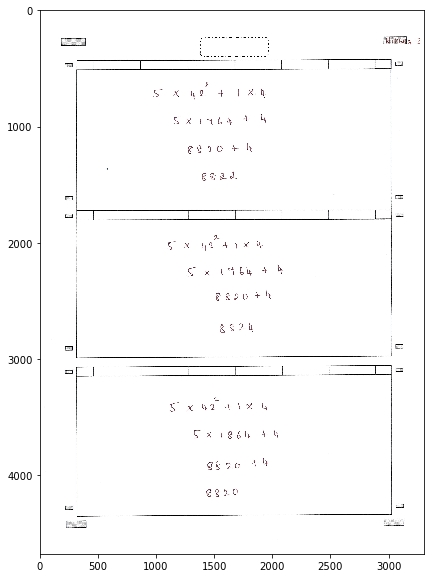

In [268]:
image_path = "C:/Users/Abhishek/Desktop/final_project/Autograding-handwritten-mathematical-worksheets-master/data/image_8.jpg"
A = 5
B = 1
X = 42
Y = 4

img = cv2.imread(image_path)
plt.figure(figsize=(10,10))
plt.imshow(img)


# Extracting WorkSpaces
This module of the algorithm assumes that there are rectangular boxes in the images of the worksheet with handwritten texts. Then it looks for reectangular boxes i.e closed object contours, then sorts the countours using the coordinates and finally selecting the required boxes based on the area.


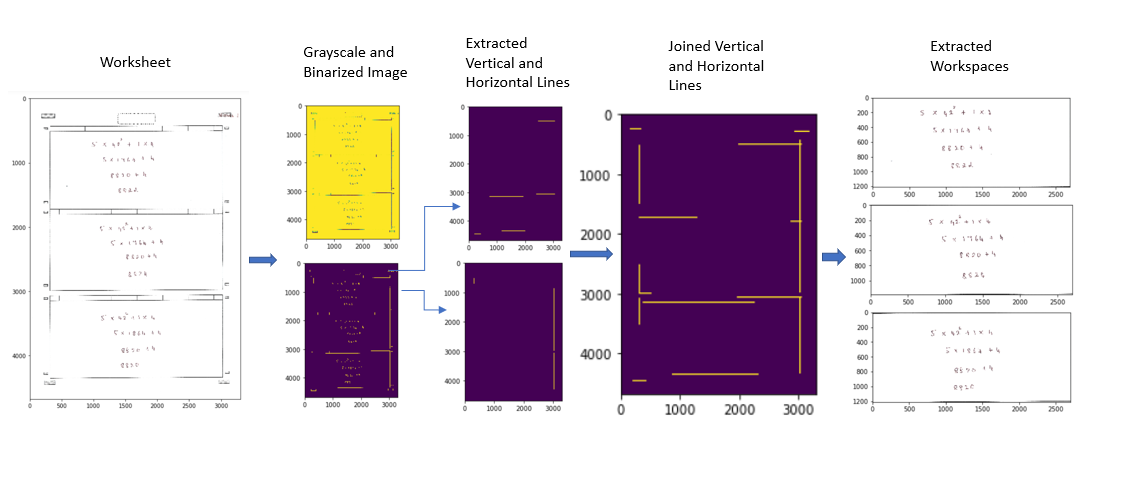

In [269]:
# All steps involved during Extraction of Workspce
display.Image("C:/Users/Abhishek/Desktop/final_project/Autograding-handwritten-mathematical-worksheets-master/project_images/ExtractionWorkspaces.png")

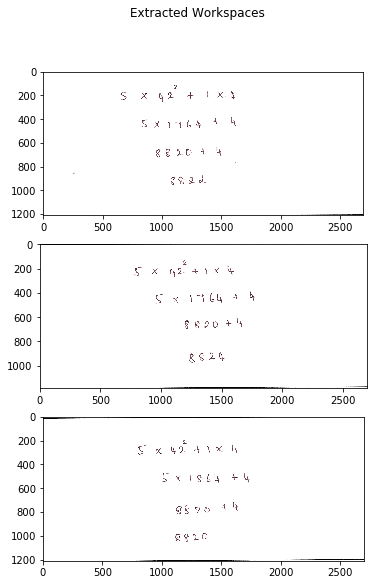

In [270]:
#Workspaces Detection
workspaces = extract_box(img) # calling the extract_worspaace fucntion and storing the locations of the each detected workspace.

## Detection of Line from each identified workspaces 

The line detection program assumes that there is a sufficient space between lines and that exponential characters and lines meet at some point. To take the forward derivative, the identified work-spaces are first transformed to binary pictures, then compressed in a single array. This method of line detection is known as "Line detection using forward derivative", There will be a modification in the derivative whenever there is a line.


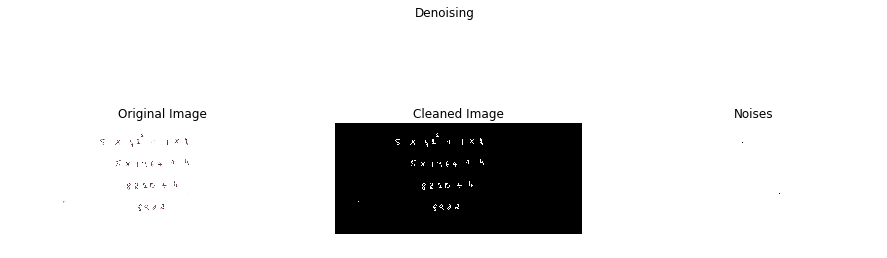

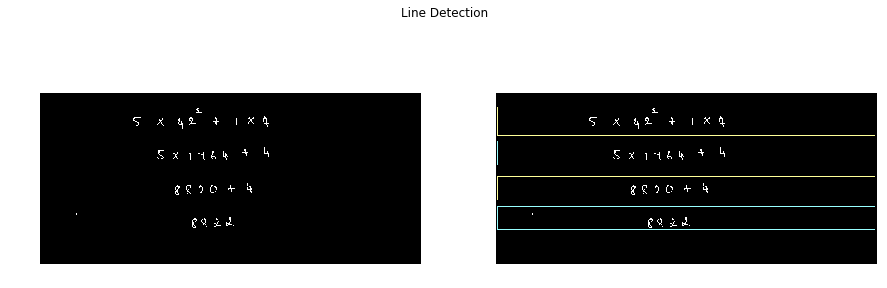

    y1   y2  x1    x2  box_num
0  105  305   0  2696        0
1  346  515   0  2696        0
2  596  761   0  2696        0
3  806  968   0  2696        0


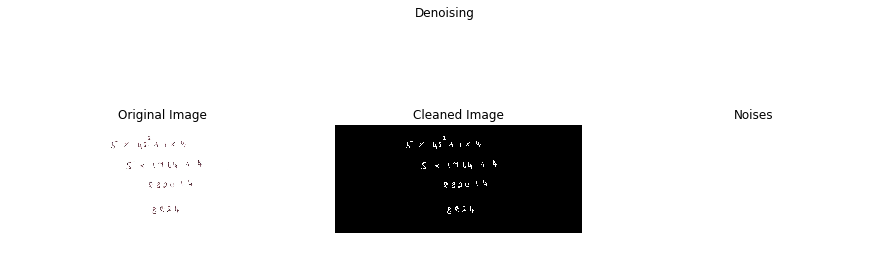

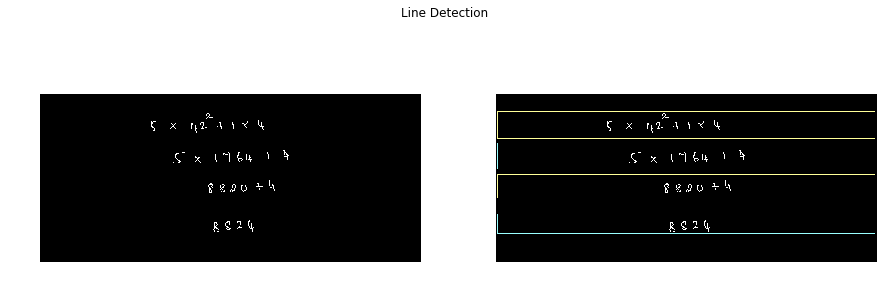

    y1   y2  x1    x2  box_num
0  125  315   0  2696        1
1  346  528   0  2696        1
2  568  733   0  2696        1
3  846  986   0  2696        1


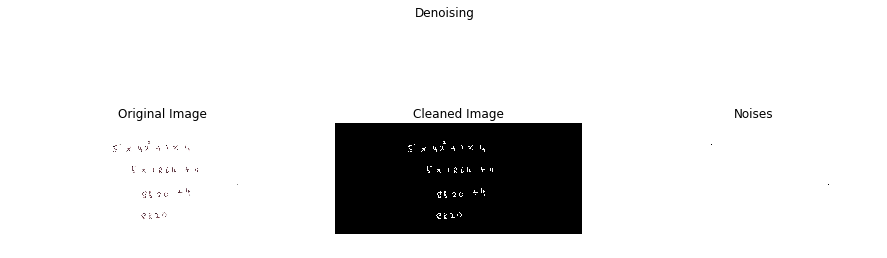

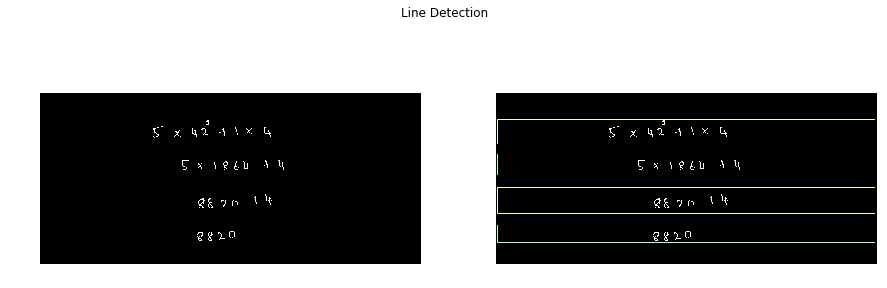

    y1    y2  x1    x2  box_num
0  185   360   0  2699        2
1  431   581   0  2699        2
2  667   855   0  2699        2
3  934  1057   0  2699        2


In [271]:
# Creating a dataframe to store information about each detected line
df_lines = pd.DataFrame()

for r,rect in enumerate(workspaces): 
    #For forwarding to the line detection module, cropping boxes.
    box = img[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
    H,W = box.shape[:2]
    #Extraction of lines from the boxes
    cleaned_orig,y1s,y2s = line_extraction(box, show=True)
    x1s = [0]*len(y1s)
    x2s = [W]*len(y1s)
    
    
    df = pd.DataFrame([y1s,y2s,x1s,x2s]).transpose()
    df.columns = ['y1','y2','x1','x2']
    df['box_num'] = r

    df_lines= pd.concat([df_lines, df])

    clean_image_dict.update({r:cleaned_orig})
    original_image_dict.update({r:box})
    
    print(df)

df_lines['line_name'] = ['%d%d' %(df_lines.box_num.iloc[i],df_lines.index[i]) \
        for i in range(len(df_lines))]
    
    

## Character segmentation 


After identifying all of the lines, we must pass the extracted line images to the text segment function, which will segment the characters using openCV's cv2.findContour() function and sort them using the function sort contours mentioned before, with the method set to left-to-right.
It's simple for humans to determine if a given number is an exponent or not, but it's not so simple for the model. Assuming that the exponents are at least half of the line, we may draw a baseline in the image's center and consider every character that is above it to be an exponent.

Optical Character recognition is performed using the DCCNN model trained earlier on MNIST digits and Kaggle's symbols datasets.

Any character whose bottom right corner point lies above the centre of the image is considered as exponents

### Results
Exponents are in green bounding boxes, Pink text represents predictions
























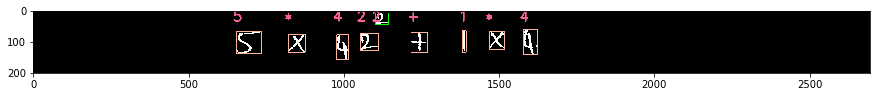

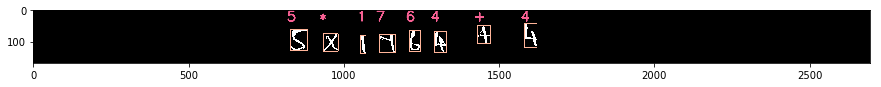

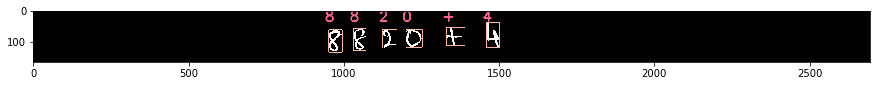

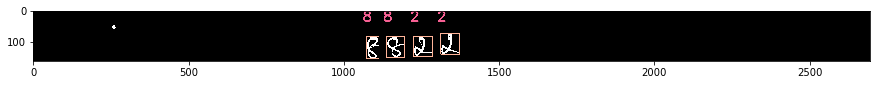

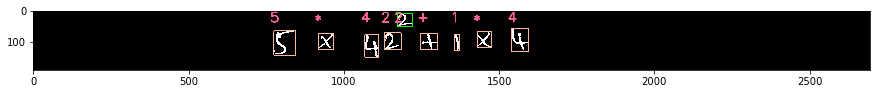

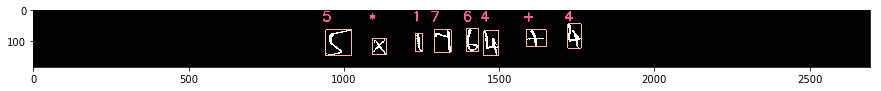

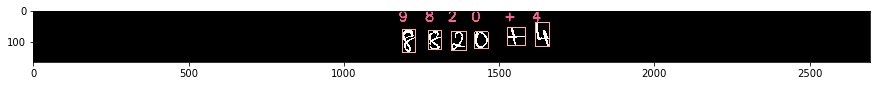

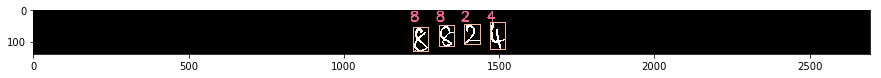

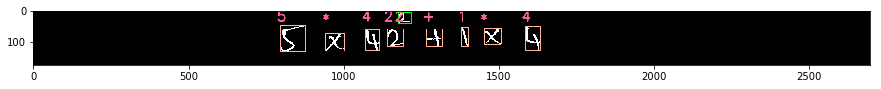

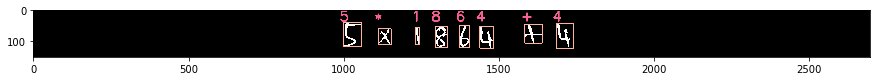

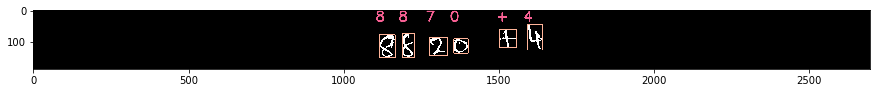

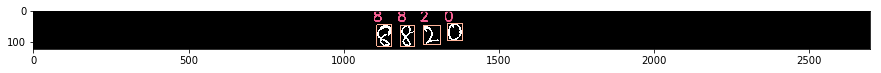

In [272]:
#All characters' positions, as well as box num and line name, are stored in df list_chars.
list_chars = list(df_lines.apply(lambda row: text_segment(row['y1'],row['y2'],\
                 row['x1'],row['x2'], row['box_num'],row['line_name'], \
                 show=True), axis=1))
    


## Evaluation

eval method in Python allows us to evaluate arbitrary Python expressions from a text or compiled code input. When we need to dynamically evaluate Python expressions from any input, whether it's a string or a built code object, this method comes in useful. So, it is used to solve any arithmetic equation identified  from each extracted lines. The built-in Python eval function may be used to dynamically evaluate expressions from a string or compiled code input. When we give eval a text, it parses it, converts it to bytecode, and evaluates it as a Python expression. When we call eval with a built code object, however, the method just executes the evaluation step, which is useful if you run eval several times with the same input. During the assessment process:

Each equation is solved and the answer is stored for verification in the next steps. Then each handwritten line identified is calculated and the results are then compared to the saved answer. Finally If the equation in a particular line is correctly solved,then a green bounding box is drawn;else if it is incorrect, then red box is draw and blue indicates undetermined.


BOX 1
5*42**2+1*4
5*1764+4
8820+4
8822
BOX 2
5*42**2+1*4
5*1764+4
9820+4
8824
BOX 3
5*42**2+1*4
5*1864+4
8870+4
8820


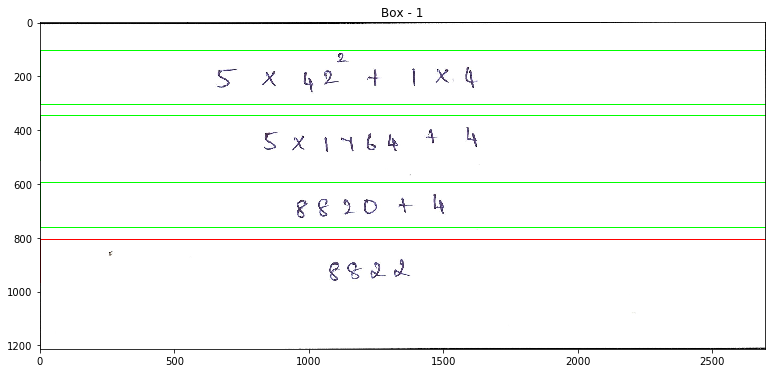

<Figure size 432x288 with 0 Axes>

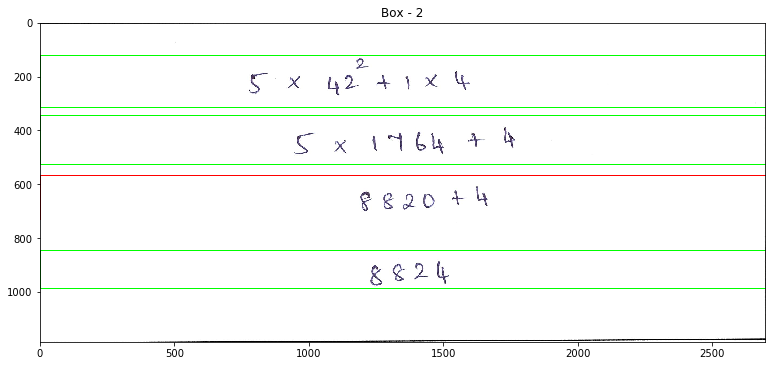

<Figure size 432x288 with 0 Axes>

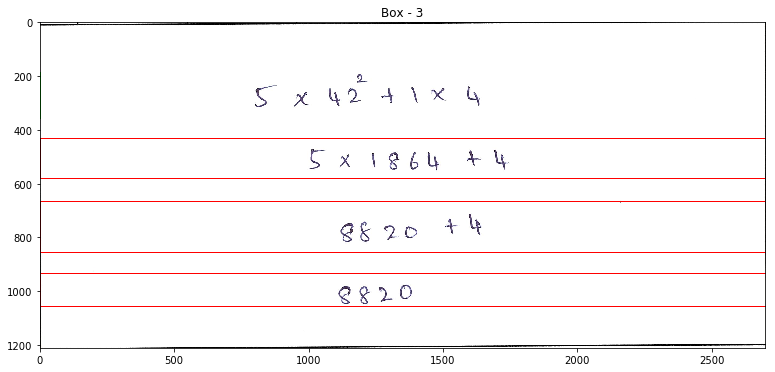

<Figure size 432x288 with 0 Axes>

In [273]:
df_chars = pd.DataFrame(list_chars)
df_chars.columns = ['box_num', 'line_name', 'char_df']
    
box_nums = df_chars.box_num.unique()
char_area_list = []
df_chars['char_df'].apply(lambda d: char_area_list.append(list(d['area'])) )

#Area based threshold for detecting and removing noises
gamma = 0
max_ar = max([max(i) for i in char_area_list])
ar_thresh = max_ar*gamma

#Keeping only those characters whose area of contours is above area threshold
df_chars['char_df'] = df_chars['char_df'].apply(lambda d: d[d.area > ar_thresh] )

for bn in box_nums:
    print('BOX %d' %(bn+1))
    box_img = clean_image_dict[bn] #For Processing B/W image
    box_img_1 = original_image_dict[bn] #For saving results
    box_img = cv2.cvtColor(box_img, cv2.COLOR_GRAY2BGR)
    
    df = df_chars[df_chars.box_num == bn].copy()
    df_l = df_lines[df_lines["box_num"]==bn].copy() #Defining dF with line info
    
    df['char_df'].apply(lambda d: d.apply(lambda c: cv2.rectangle(box_img, \
      (c['X1'],c['Y1']),(c['X2'], c['Y2']),(255*(c['exp']==1),180,0),2+(2*c['exp'])), axis=1 ) )
    
    df['line_status'] = df['char_df'].apply(lambda d: evaluate(d[["pred","exp","pred_proba"]],A,B,X,Y))
    
    scale_percent = 200 # percent of original size
    width = int(box_img.shape[1] * scale_percent / 100)
    height = int(box_img.shape[0] * scale_percent / 100)
    dim = (width, height)    
    box_img = cv2.resize(box_img, dim, interpolation = cv2.INTER_AREA)

    #Drawing rectangle on original Image
    df_l['line_status'] = list(df['line_status']) 
    df_l.apply(lambda c: cv2.rectangle(box_img_1, (c['x1'],c['y1']),(c['x2'],\
      c['y2']),(255*(c['line_status']==5),255*(c['line_status']==True),\
                                255*(c['line_status']==False)),2), axis=1)
    
    plt.figure(figsize=(13,7))
    plt.title('Box - %d' %(bn+1) )
    plt.imshow(cv2.cvtColor(box_img_1, cv2.COLOR_BGR2RGB))
    plt.figure()



From the above evaluation module result's it can be observed that:
+ For box1 (Detected Workspace 1) all equations were solved correctly as indicated by the green box marking, whereas the final result was incorrect since its marked in red box.
+ For box2 (Detected Workspace 2) all the equations were solved correctly.
+ For box3 (Detected Workspace 3) all the equations were solved incorrectly as they are all marked in red boxes.